In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from sklearn.model_selection import train_test_split
import glob
from tensorflow.keras.layers import concatenate, Flatten
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.models import Model

# Load Image

In [3]:
# load image
filelist_input = glob.glob("C:/Users/s4520948/Downloads/ISIC2018_Task1-2_Training_Input_x2/*.jpg")
filelist_ground_truth = glob.glob("C:/Users/s4520948/Downloads/ISIC2018_Task1_Training_GroundTruth_x2/*.png")

In [4]:
# check size
print(len(filelist_input))
print(len(filelist_ground_truth))

2594
2594


# Pre-process

In [5]:
def convert_array(filelist):
    '''# convert training image to array and resize
    '''
    data = []
    for fname in filelist:
        image = np.asarray(PIL.Image.open(fname))
        image = tf.image.resize(image, (256,256))
        data.append(image)
    data = np.array(data, dtype=np.float32)
    return data

In [6]:
def convert_array_truth(filelist):
    '''convert ground truth image to array and resize
    '''
    data = []
    for fname in filelist:
        image = np.asarray(PIL.Image.open(fname))
        image = image[:,:,np.newaxis]
        image = tf.image.resize(image, (256,256), method = 'nearest')
        data.append(image)
    data = np.array(data, dtype=np.uint8)
    return data

In [7]:
# convert input image to array
x = convert_array(filelist_input)

In [8]:
# rescale
x = x / 255.

In [9]:
# convert ground truth to array
y = convert_array_truth(filelist_ground_truth)

In [10]:
y = np.round(y / 255)

# Sample image

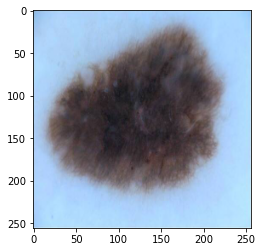

In [34]:
plt.imshow(x[0])

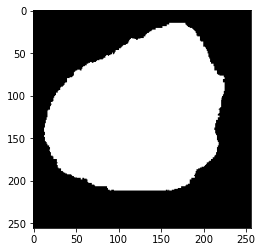

In [36]:
plt.imshow(y[0],cmap='gray')

# Train Test Split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
# check shapes
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

x.shape: (2594, 256, 256, 3)
y.shape: (2594, 256, 256, 1)
x_train.shape: (2075, 256, 256, 3)
x_test.shape: (519, 256, 256, 3)
y_train.shape: (2075, 256, 256, 1)
y_test.shape: (519, 256, 256, 1)


# Define model

In [24]:
def model():
    input_layer = tf.keras.layers.Input(shape=(256,256,3))

    x = Conv2D(64,(3,3), activation='relu', padding='same')(input_layer)
    x1 = Conv2D(64,(3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x1)
    x = Conv2D(128,(3,3), activation='relu', padding='same')(x)
    x2 = Conv2D(128,(3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x2)
    x = Conv2D(256,(3,3), activation='relu', padding='same')(x)
    x3 = Conv2D(256,(3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x3)
    x = Conv2D(512,(3,3), activation='relu', padding='same')(x)
    x4 = Conv2D(512,(3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(1024,(3,3), activation='relu', padding='same')(x)
    encoded = Conv2D(1024,(3,3), activation='relu', padding='same')(x)

    u4 = UpSampling2D((2,2))(encoded)
    x = concatenate([x4, u4])
    x = Conv2D(1024,(3,3), activation='relu', padding='same')(x)
    x = Conv2D(512,(3,3), activation='relu', padding='same')(x)
    u3 = UpSampling2D((2,2))(x)
    x = concatenate([x3, u3])
    x = Conv2D(512,(3,3), activation='relu', padding='same')(x)
    x = Conv2D(256,(3,3), activation='relu', padding='same')(x)
    u2 = UpSampling2D((2,2))(x)
    x = concatenate([x2, u2])
    x = Conv2D(256,(3,3), activation='relu', padding='same')(x)
    x = Conv2D(128,(3,3), activation='relu', padding='same')(x)
    u1 = UpSampling2D((2,2))(x)
    x = concatenate([x1, u1])
    x = Conv2D(128,(3,3), activation='relu', padding='same')(x)
    x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
    x = Conv2D(64,(3,3), activation='relu', padding='same')(x)

    decoded = Conv2D(1,(1,1), activation='sigmoid')(x)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

In [25]:
def fit(model,x,y, epoch_size, batch):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                     metrics=['accuracy'])

    model.fit(x, y, epochs=epoch_size, batch_size=batch,
                    validation_split=0.2)

In [26]:
model = model()

# Fit model

In [27]:
fit(model,x_train,y_train,10,4)

Train on 1660 samples, validate on 415 samples
Epoch 1/10
1660/1660 [==============================] - 98s 59ms/sample - loss: 0.3868 - accuracy: 0.8375 - val_loss: 0.3539 - val_accuracy: 0.8992
Epoch 2/10
1660/1660 [==============================] - 99s 60ms/sample - loss: 0.2589 - accuracy: 0.9089 - val_loss: 0.2327 - val_accuracy: 0.9166
Epoch 3/10
1660/1660 [==============================] - 99s 60ms/sample - loss: 0.2164 - accuracy: 0.9212 - val_loss: 0.2020 - val_accuracy: 0.9269
Epoch 4/10
1660/1660 [==============================] - 100s 60ms/sample - loss: 0.1854 - accuracy: 0.9292 - val_loss: 0.2023 - val_accuracy: 0.9256
Epoch 5/10
1660/1660 [==============================] - 100s 60ms/sample - loss: 0.1849 - accuracy: 0.9314 - val_loss: 0.1879 - val_accuracy: 0.9295
Epoch 6/10
1660/1660 [==============================] - 100s 60ms/sample - loss: 0.1730 - accuracy: 0.9340 - val_loss: 0.1796 - val_accuracy: 0.9325
Epoch 7/10
1660/1660 [==============================] - 100s 6

# Prediction

In [28]:
pred = model.predict(x_test,batch_size=4)

In [29]:
pred_mask = np.round(pred)

In [19]:
import tensorflow.keras.backend as K 
def dice_coef(y_true, y_pred, smooth=1.):
    '''calculate dice similarity coefficient
    '''
    y_true = tf.convert_to_tensor(y_true, dtype='float32')
    y_pred = tf.convert_to_tensor(y_pred, dtype='float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [30]:
# dice coefficient
dice = dice_coef(y_test, pred_mask, smooth=1.)
print(dice)

tf.Tensor(0.8408494, shape=(), dtype=float32)


# Results display

In [22]:
def display(display_list):
    '''plot the input image, true mask and predicted mask accordingly'''
    plt.figure(figsize=(15, 15))
    title= ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap="gray")
        plt.axis('off')
    plt.show()

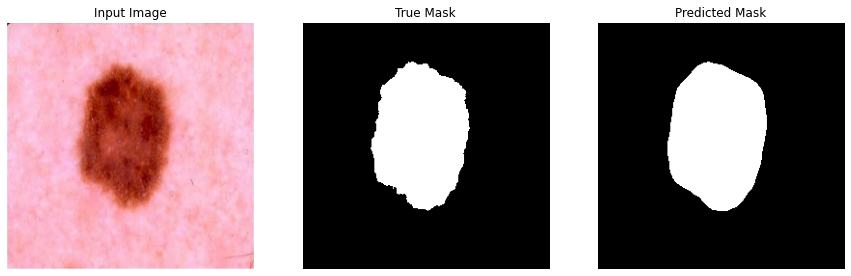

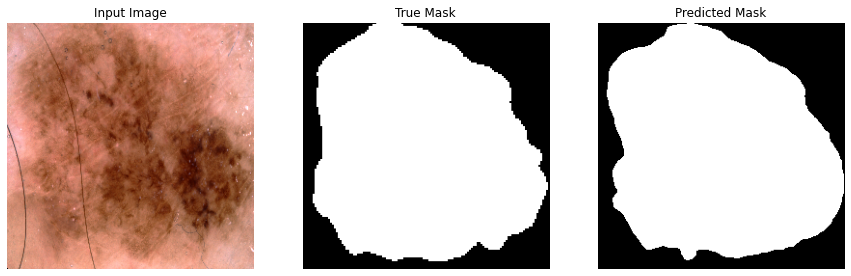

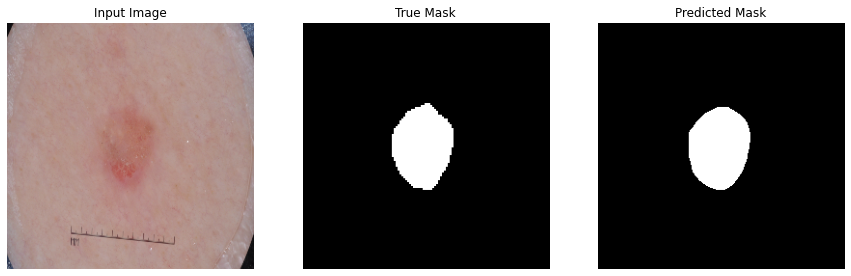

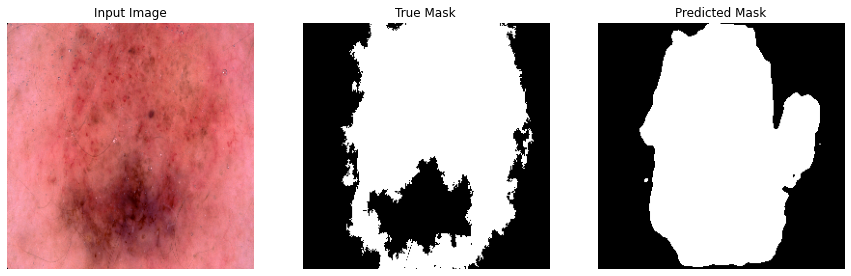

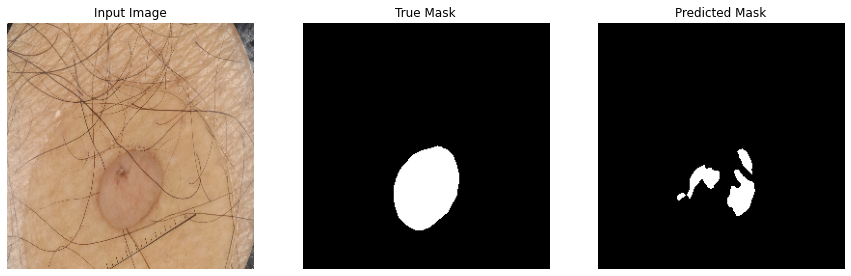

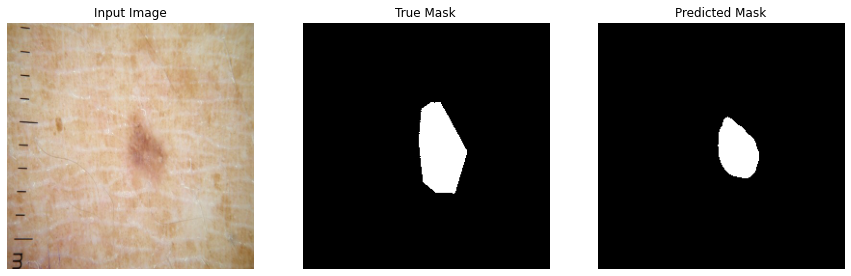

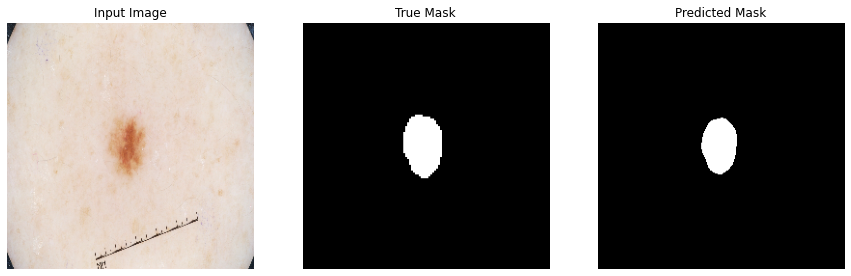

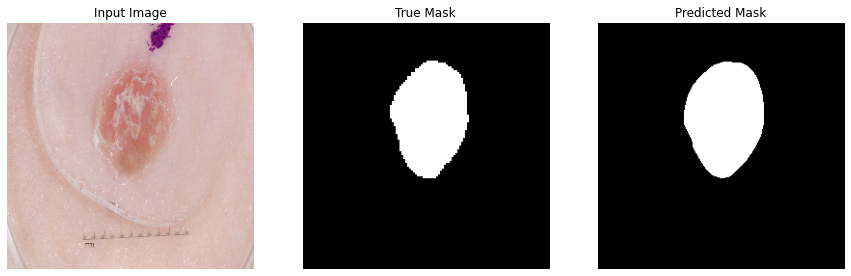

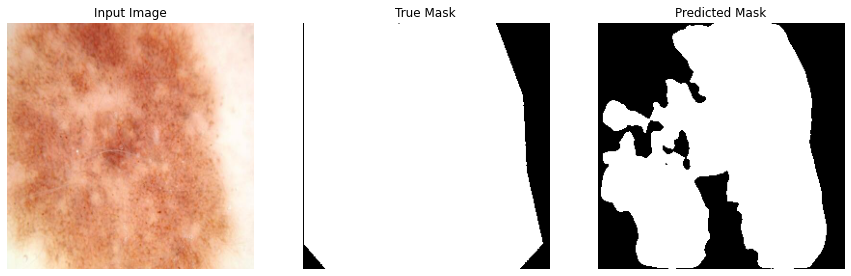

In [31]:
for i in range(9):
    display([x_test[i],y_test[i],pred_mask[i]])